In [1]:
import torch
from torch import nn

torch.__version__

'2.5.1+cu124'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Dataset

Our dataset is a subset of Food 101 dataset, its formatted in standard image clasification data format:

```
dataset/
  train/
    class1/
      image1.jpg
      image2.jpg
      ...
    class2/
      image64.jpg
      image65.jpg
      ...
  test/
    class1/
      image127.jpg
      image128.jpg
      ...
    class2/
      image196.jpg
      image197.jpg
      ...
```

The goal will be to take this data storage structure and turn it into a dataset usable with PyTorch



In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print("Already Exists")
else:
  image_path.mkdir(parents=True, exist_ok = True)

# Download data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(request.content)

# Unzip
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  zip_ref.extractall(image_path)

In [4]:
import os
def traverse_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [5]:
traverse_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Visualize

1. Get all of the image paths using pathlib.Path.glob() to find all of the files ending in .jpg.
2. Pick a random image path using Python's random.choice().
3. Get the image class name using pathlib.Path.parent.stem.
4. And since we're working with images, we'll open the random image path using PIL.Image.open() (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.

data/pizza_steak_sushi/test/pizza/194643.jpg
pizza
Width: 382
Height: 512
Image mode: RGB


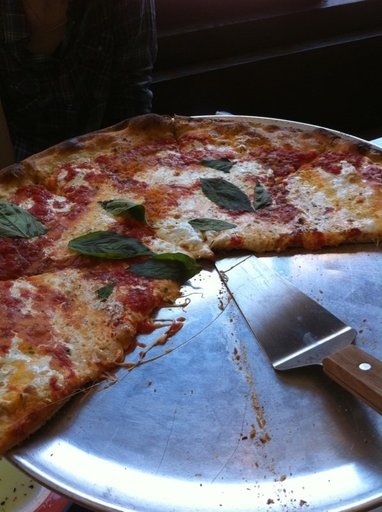

In [7]:
import random
from PIL import Image

#random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))
# A list of paths of all images in the entire dataset

random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)

print(f"Width: {img.width}")
print(f"Height: {img.height}")
print(f"Image mode: {img.mode}")
img

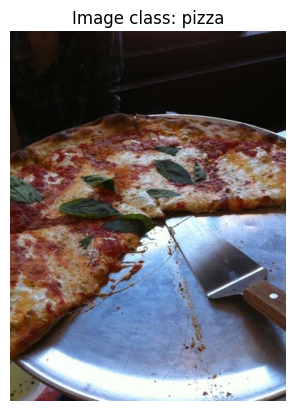

Image shape: (512, 382, 3)


In [8]:
import numpy as np
import matplotlib.pyplot as plt

img_array = np.asarray(img)

plt.imshow(img_array)
plt.axis(False)
plt.title(f"Image class: {image_class}")
plt.show()

print(f"Image shape: {img_array.shape}")

### Transforming Data

- Turn it into tensors (numerical representations of our images).
- Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these Dataset and DataLoader for short.

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [10]:
# Making a transform for image to pass while making dataset

data_transform = transforms.Compose([ # To combine multiple transfomations (we can also use nn.Sequential)
    transforms.Resize((64, 64)), # Resize
    transforms.RandomHorizontalFlip(p=0.5), # Data augmentation
    transforms.ToTensor()
])

# It will take PIL Image only, not np array

In [11]:
transformed = data_transform(img)
transformed.shape

torch.Size([3, 64, 64])

In [12]:
def plot_transformed_images(image_paths, transform, n=3):
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size: {f.size}")
      ax[0].axis("off")

      transformed_image = transform(f).permute(1, 2, 0) # matplotlib doesnt take (C, H, W)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Size: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}")
      plt.show()

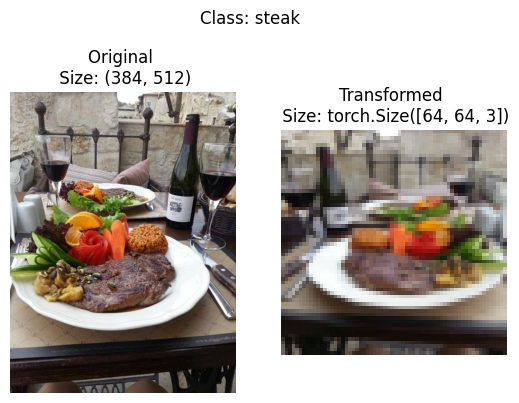

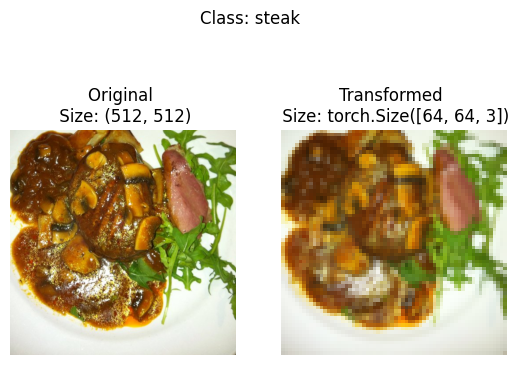

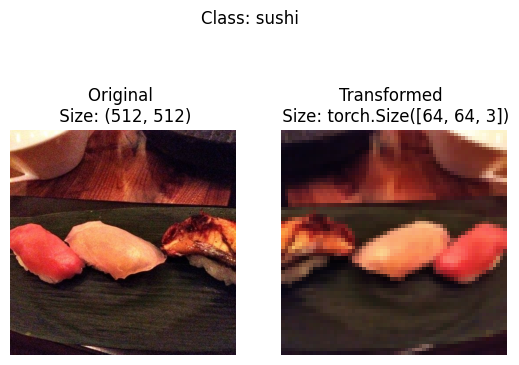

In [13]:
plot_transformed_images(image_path_list, transform=data_transform, n=3)

## Loading Image Data

### Option 1: ImageFolder

Since our data is in standard image classification format, we can use the class torchvision.datasets.ImageFolder.

Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.

In [14]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # For data
                                  target_transform=None) # For target (not needed)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform, # For data
                                  target_transform=None) # For target (not needed)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
class_names = train_data.classes
class_dict = train_data.class_to_idx
class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [16]:
len(train_data), len(test_data)

(225, 75)

In [17]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [18]:
image, label = test_data[0]
print(f"Image tensor: {image}")
print(f"Image shape: {image.shape}")
print(f"Image datatype: {image.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")


Image tensor: tensor([[[0.1020, 0.1333, 0.0824,  ..., 0.3725, 0.2039, 0.0471],
         [0.1137, 0.1255, 0.0784,  ..., 0.2667, 0.1961, 0.2000],
         [0.1255, 0.1255, 0.1059,  ..., 0.1333, 0.1176, 0.0980],
         ...,
         [0.0980, 0.1059, 0.0863,  ..., 0.0235, 0.0196, 0.0196],
         [0.0941, 0.1020, 0.0863,  ..., 0.0235, 0.0235, 0.0196],
         [0.0863, 0.0980, 0.0980,  ..., 0.0235, 0.0196, 0.0196]],

        [[0.0235, 0.0353, 0.0235,  ..., 0.2471, 0.1255, 0.0196],
         [0.0235, 0.0275, 0.0157,  ..., 0.1608, 0.1216, 0.1333],
         [0.0235, 0.0196, 0.0314,  ..., 0.0784, 0.0667, 0.0588],
         ...,
         [0.0196, 0.0235, 0.0196,  ..., 0.0078, 0.0039, 0.0039],
         [0.0196, 0.0235, 0.0196,  ..., 0.0078, 0.0078, 0.0039],
         [0.0196, 0.0235, 0.0314,  ..., 0.0078, 0.0039, 0.0039]],

        [[0.0039, 0.0078, 0.0039,  ..., 0.0588, 0.0392, 0.0118],
         [0.0039, 0.0078, 0.0039,  ..., 0.0431, 0.0314, 0.0510],
         [0.0039, 0.0078, 0.0196,  ..., 0.03

In [19]:
image_permute = image.permute(1, 2, 0)
print(f"Now: {image_permute.shape}") # PyTorch takes H, W, C
print(f"Before: {image.shape}")

Now: torch.Size([64, 64, 3])
Before: torch.Size([3, 64, 64])


#### Making DataLoader

In [20]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f840e263b50>,
 <torch.utils.data.dataloader.DataLoader at 0x7f840e12f490>)

In [21]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [22]:
img, label = next(iter(train_dataloader))

img.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### Option 2: Loading Image Data with Custom Dataset

Subclass torch.utils.data.Dataset

In [23]:
import os
import pathlib

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [24]:
# To get class names, using os.scandir()

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted([entry.name for entry in list(os.scandir(directory))])
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}")
  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx

find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [25]:
# Custom dataset

class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir: str,
               transform=None):
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index:int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  # Overwrite __len__()
  def __len__(self) -> int:
    return len(self.paths)

  # Overwrite __getitem__()
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    image = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(image), class_idx
    else:
      return image, class_idx

In [26]:
train_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(size=(64,64)),
                                      transforms.ToTensor()])


In [27]:
train_data_custom = ImageFolderCustom(train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(test_dir, transform=test_transforms)

len(train_data_custom), len(test_data_custom)

(225, 75)

In [28]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [29]:
# Random Images

def display_random(dataset: torch.utils.data.Dataset,
                   classes: List[str] = None,
                   n: int = 10,
                   display_shape: bool = True,
                   seed: int = None):
  if n > 10:
    n = 10
    display_shape = False

  if seed:
    random.seed(seed)

  random_sample_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_sample_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    targ_image_adjust = targ_image.permute(1, 2, 0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title=(f"Class: {classes[targ_label]}")
      if display_shape:
        title+=(f"\nShape: {targ_image_adjust.shape}")

    plt.title(title)

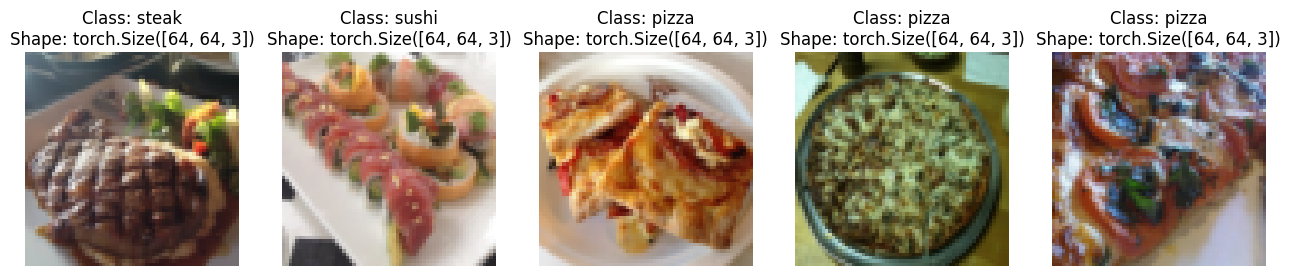

In [30]:
display_random(train_data_custom, classes=class_names, n=5, display_shape=True)

#### Make DataLoader

In [31]:
os.cpu_count()

2

In [32]:
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=os.cpu_count(),
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=os.cpu_count(),
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f840d58ec10>,
 <torch.utils.data.dataloader.DataLoader at 0x7f840d56ee10>)

In [33]:
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## Data Augmentaion (Type of Transformations)

Artificially add diversity to the data

In [34]:
train_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31), # Intensity of augmentation (0-31)
                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                      transforms.ToTensor()])

In [35]:
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/train/steak/3142674.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1976160.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1839481.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/461689.jpg'),
 PosixPath('data/pizza_steak_sushi/train/steak/1787505.jpg')]

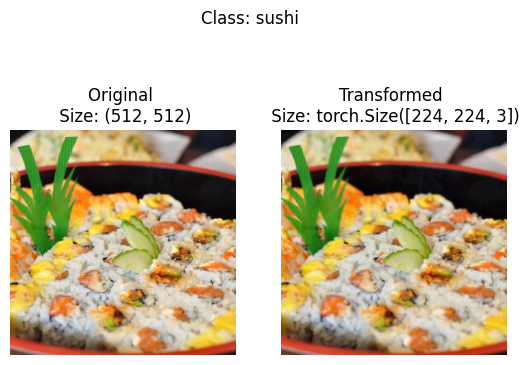

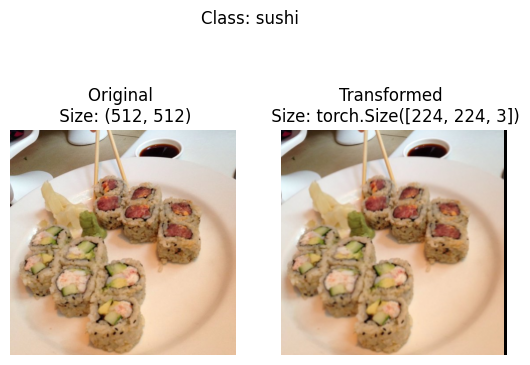

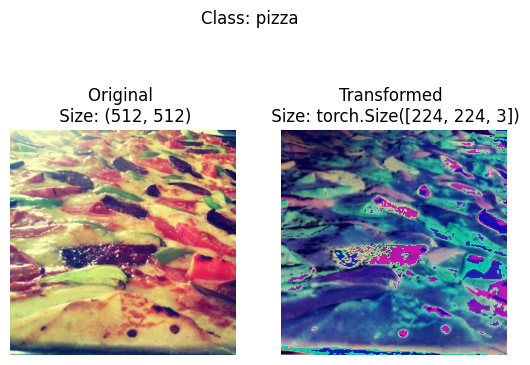

In [36]:
plot_transformed_images(image_path_list, train_transform, n=3)

## Baseline Model (No Augmentation)

In [37]:
# Transforms
simple_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                       transforms.ToTensor()])

In [38]:
# Datasets
train_data_simple = datasets.ImageFolder(root = train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)
# DataLoader
BATCH_SIZE = 32
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=os.cpu_count())
test_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=os.cpu_count())

In [39]:
# TinyVGG Model
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int)-> None:
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x))) # Operator Fusion

In [40]:
model = TinyVGG(input_shape=3,
                hidden_units=10,
                output_shape=len(class_names)).to(device)

model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [41]:
img_batch, label_batch = next(iter(train_dataloader_simple))

img_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [42]:
with torch.inference_mode():
  print(model(img_batch.to(device)).shape)

torch.Size([32, 3])


```
RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1690 and 10x3)
```

This explain that we need to multiply the hidden units of classifier block with 13*13

#### Torchinfo (makes life easier)

In [43]:
!pip install torchinfo

In [44]:
from torchinfo import summary
summary(model, input_size=(32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

In [45]:
# Train Step

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  model.train()
  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc


In [46]:
# Test Step

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():

    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred = model(X)

      loss = loss_fn(test_pred, y)
      test_loss += loss.item()

      test_pred_class = test_pred.argmax(dim=1) # Same result as using with softmax
      test_acc += (test_pred_class==y).sum().item()/len(test_pred_class)

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc


In [47]:
# Training

from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=5,
          device = device):

  results = {"train_loss": [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn)

    print(f"Epoch:: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [48]:
from timeit import default_timer as timer

NUM_EPOCHS = 20

model = TinyVGG(input_shape=3,
                hidden_units=10,
                output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr=0.001)

start_time = timer()

model_results = train(model, train_dataloader_simple, test_dataloader_simple, optimizer, loss_fn, NUM_EPOCHS, device)

end_time = timer()

print(f"Time Taken: {end_time-start_time: .3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:: 0 | Train Loss: 1.1133 | Train Acc: 0.2695 | Test Loss: 1.1032 | Test Acc: 0.3047
Epoch:: 1 | Train Loss: 1.0922 | Train Acc: 0.3125 | Test Loss: 1.0877 | Test Acc: 0.3984
Epoch:: 2 | Train Loss: 1.1054 | Train Acc: 0.2852 | Test Loss: 1.0816 | Test Acc: 0.3047
Epoch:: 3 | Train Loss: 1.0920 | Train Acc: 0.3203 | Test Loss: 1.0934 | Test Acc: 0.3516
Epoch:: 4 | Train Loss: 1.0775 | Train Acc: 0.5117 | Test Loss: 1.0727 | Test Acc: 0.4102
Epoch:: 5 | Train Loss: 1.0616 | Train Acc: 0.3555 | Test Loss: 1.0519 | Test Acc: 0.3555
Epoch:: 6 | Train Loss: 1.0182 | Train Acc: 0.4375 | Test Loss: 0.9768 | Test Acc: 0.6172
Epoch:: 7 | Train Loss: 1.1361 | Train Acc: 0.4492 | Test Loss: 0.9097 | Test Acc: 0.5078
Epoch:: 8 | Train Loss: 0.9491 | Train Acc: 0.5898 | Test Loss: 0.9673 | Test Acc: 0.4375
Epoch:: 9 | Train Loss: 0.9301 | Train Acc: 0.5938 | Test Loss: 0.8949 | Test Acc: 0.5742
Epoch:: 10 | Train Loss: 0.9648 | Train Acc: 0.4414 | Test Loss: 0.8880 | Test Acc: 0.6562
Epoch:: 1

###  Loss Curve

In [49]:
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [50]:
def plot_loss_curves(results: Dict[str, List[float]]):
  train_loss = results["train_loss"]
  test_loss = results["test_loss"]

  train_acc = results["train_acc"]
  test_acc = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_acc, label="train_acc")
  plt.plot(epochs, test_acc, label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

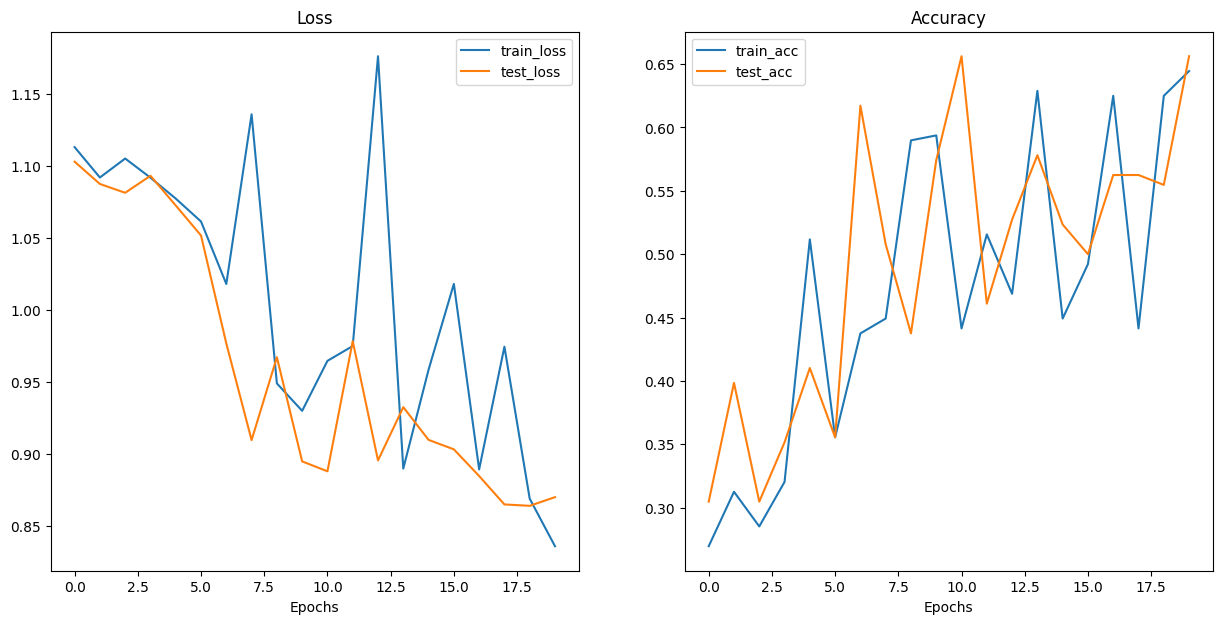

In [51]:
plot_loss_curves(model_results)

## New Model with Augmentation

In [52]:
# Transform

train_transform_trivial = transforms.Compose([transforms.Resize(size=(64, 64)),
                                             transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                              transforms.ToTensor()])
test_transform_simple = transforms.Compose([transforms.Resize(size=(64, 64)),
                                            transforms.ToTensor()])

In [53]:
# Datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                             transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [54]:
 # Dataloaders

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [55]:
# Model

model1 = TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(train_data_augmented.classes)).to(device)

model1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [56]:
# Loss Function and Optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model1.parameters(),
                             lr=0.001)

In [57]:
# Training

NUM_EPOCHS = 20
start_time = timer()

model1_results = train(model=model1,
                       train_dataloader=train_dataloader_augmented,
                       test_dataloader=test_dataloader_simple,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

end_time = timer()
print(f"Time Taken: {end_time-start_time: .3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch:: 0 | Train Loss: 1.1107 | Train Acc: 0.2500 | Test Loss: 1.0941 | Test Acc: 0.5417
Epoch:: 1 | Train Loss: 1.1005 | Train Acc: 0.2695 | Test Loss: 1.0990 | Test Acc: 0.2604
Epoch:: 2 | Train Loss: 1.1056 | Train Acc: 0.3047 | Test Loss: 1.0931 | Test Acc: 0.2604
Epoch:: 3 | Train Loss: 1.0969 | Train Acc: 0.3047 | Test Loss: 1.0930 | Test Acc: 0.2595
Epoch:: 4 | Train Loss: 1.1012 | Train Acc: 0.2578 | Test Loss: 1.0910 | Test Acc: 0.5417
Epoch:: 5 | Train Loss: 1.1007 | Train Acc: 0.2812 | Test Loss: 1.0909 | Test Acc: 0.5417
Epoch:: 6 | Train Loss: 1.0998 | Train Acc: 0.2812 | Test Loss: 1.0919 | Test Acc: 0.5417
Epoch:: 7 | Train Loss: 1.0963 | Train Acc: 0.4023 | Test Loss: 1.0929 | Test Acc: 0.5417
Epoch:: 8 | Train Loss: 1.0983 | Train Acc: 0.2812 | Test Loss: 1.0897 | Test Acc: 0.5417
Epoch:: 9 | Train Loss: 1.0945 | Train Acc: 0.2812 | Test Loss: 1.0830 | Test Acc: 0.3210
Epoch:: 10 | Train Loss: 1.1079 | Train Acc: 0.2617 | Test Loss: 1.0681 | Test Acc: 0.5729
Epoch:: 1

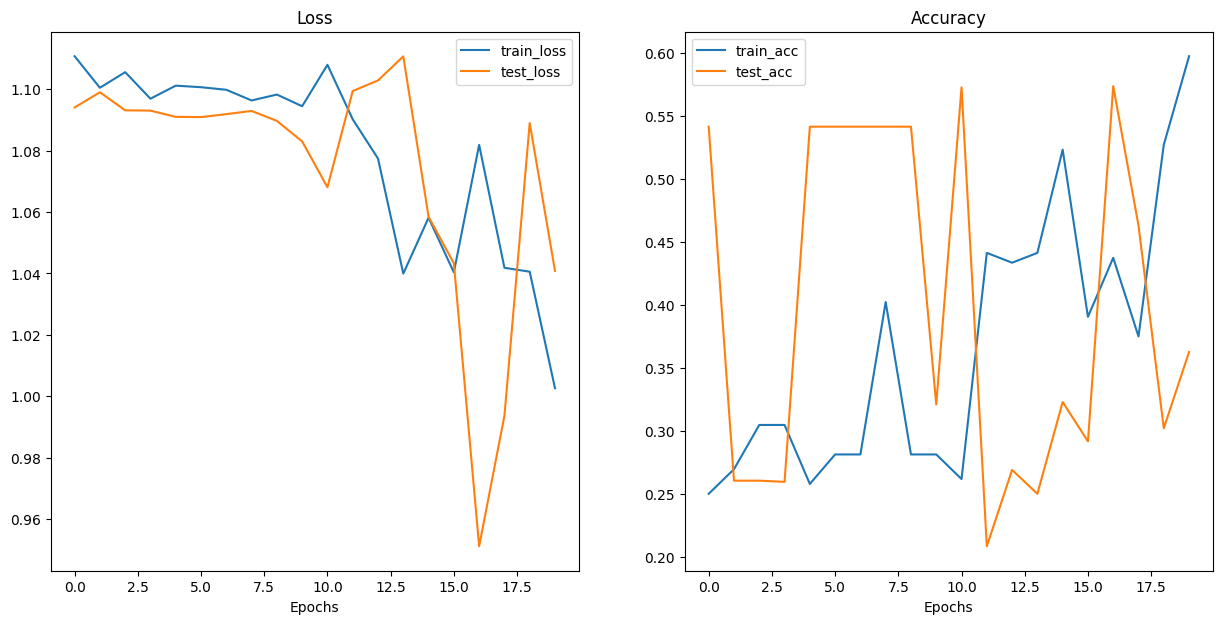

In [58]:
plot_loss_curves(model1_results)

The model is underfitting but is also overfitting

### Comparing Models

Either hardcode or use Tensorboard or Weights & Biases (library) or MLFlow

In [59]:
import pandas as pd

model0_df = pd.DataFrame(model_results)
model1_df = pd.DataFrame(model1_results)

model0_df

,train_loss,train_acc,test_loss,test_acc
0,1.113270,0.269531,1.103166,0.304688
1,1.092185,0.312500,1.087687,0.398438
2,1.105370,0.285156,1.081560,0.304688
3,1.092047,0.320312,1.093381,0.351562
4,1.077515,0.511719,1.072729,0.410156
5,1.061591,0.355469,1.051879,0.355469
6,1.018188,0.437500,0.976848,0.617188
7,1.136088,0.449219,0.909718,0.507812
8,0.949121,0.589844,0.967295,0.437500
9,0.930053,0.593750,0.894926,0.574219


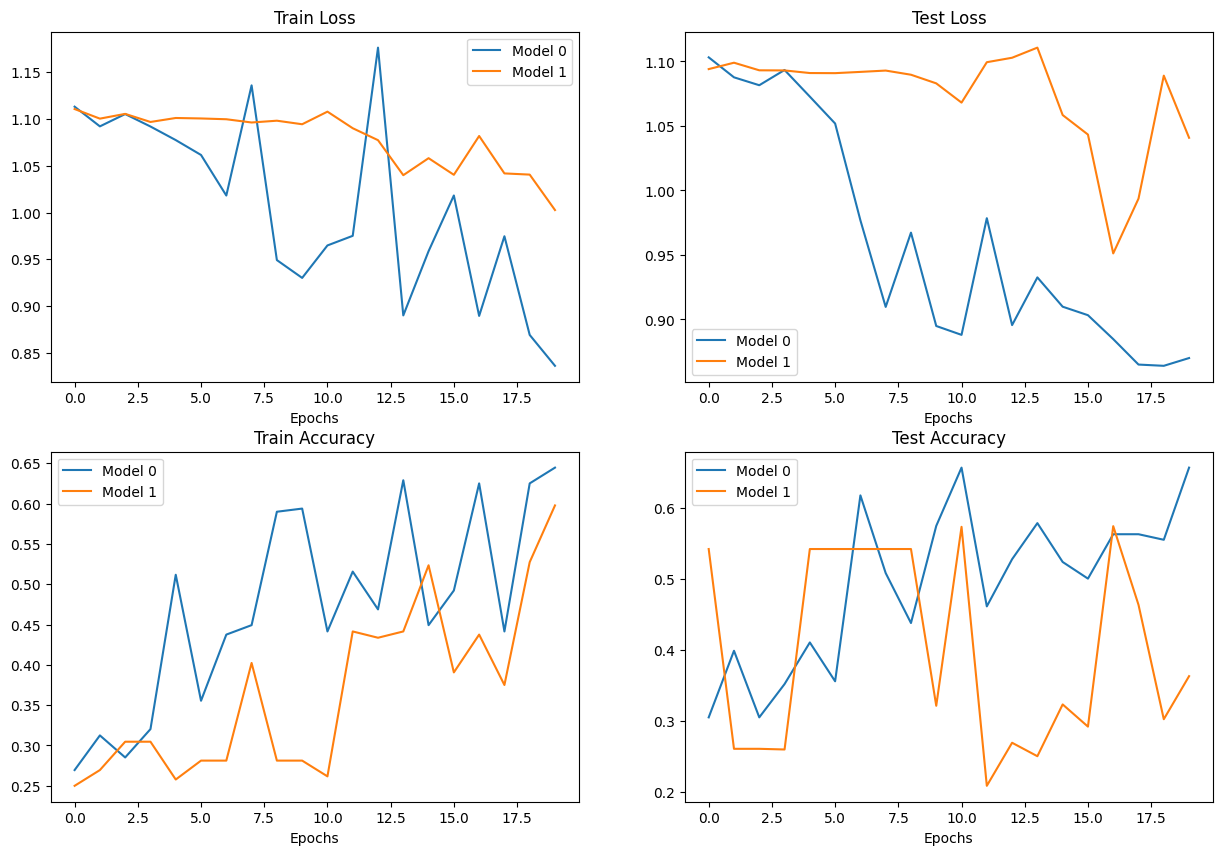

In [61]:
plt.figure(figsize=(15,10))
epochs = range(len(model0_df))

plt.subplot(2, 2, 1)
plt.plot(epochs, model0_df["train_loss"], label="Model 0")
plt.plot(epochs, model1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, model0_df["test_loss"], label="Model 0")
plt.plot(epochs, model1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, model0_df["train_acc"], label="Model 0")
plt.plot(epochs, model1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model0_df["test_acc"], label="Model 0")
plt.plot(epochs, model1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

## Make a Prediction on Any Image

In [64]:
# Download Image

import requests

custom_image_path = data_path / "pizza.jpg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://www.simplyrecipes.com/thmb/KE6iMblr3R2Db6oE8HdyVsFSj2A=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/__opt__aboutcom__coeus__resources__content_migration__simply_recipes__uploads__2019__09__easy-pepperoni-pizza-lead-3-1024x682-583b275444104ef189d693a64df625da.jpg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)


Necessary to load in PyTorch with same format, size and device

In [67]:
import torchvision

custom_image = torchvision.io.read_image(str(custom_image_path)) # Now the image is uint8
custom_image.shape, custom_image.dtype

(torch.Size([3, 682, 1024]), torch.uint8)

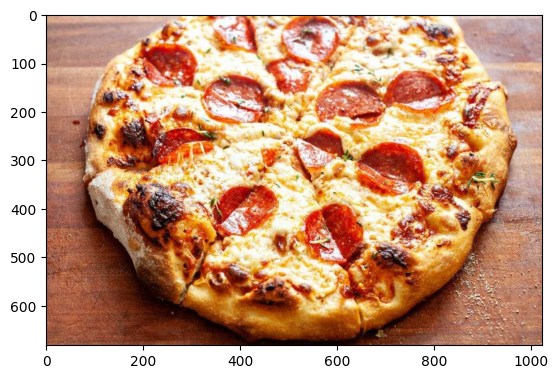

In [68]:
plt.imshow(custom_image.permute(1, 2, 0))

But our model was trained on 64 x 64, and the dtpe was float32

In [80]:
# Change to float32 and divide be 255 to scale the image between 0 and 1
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255

# Transform for resize and add batch dimension
custom_image_transform = transforms.Compose([transforms.Resize(size=(64, 64))])
custom_image_transformed = custom_image_transform(custom_image).unsqueeze(dim=0)

custom_image_transformed.shape, custom_image_transformed.dtype


(torch.Size([1, 3, 64, 64]), torch.float32)

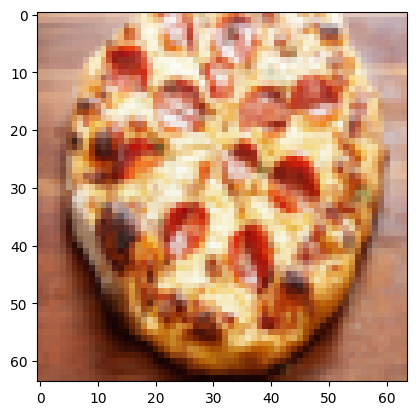

In [85]:
plt.imshow(custom_image_transformed.squeeze().permute(1, 2, 0))

In [89]:
# Remember to have batch dimension and put on same device as model
model.eval()
with torch.inference_mode():
  custom_image_pred = model(custom_image_transformed.to(device))

custom_image_pred = torch.argmax(torch.softmax(custom_image_pred, dim=1), dim=1)
class_names[custom_image_pred.cpu()]

'pizza'

In [94]:
def pred_plot(model: torch.nn.Module,
              image_path: str,
              class_names: List[str]=None,
              transform=None,
              device=device):

  image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

  image = image / 255

  if transform:
    image = transform(image)

  model.to(device)

  model.eval()
  with torch.inference_mode():
    image = image.unsqueeze(0)

    pred = model(image.to(device))
    pred_probs = torch.softmax(pred, dim=1)
    pred_label = torch.argmax(pred_probs, dim=1)

    plt.imshow(image.squeeze().permute(1, 2, 0))
    if class_names:
      title = f"Predicted: {class_names[pred_label.cpu()]} | Prob: {pred_probs.max():.3f}"
    else:
      title = f"Predicted: {pred_label} | Prob: {pred_probs.max():.3f}"
    plt.title(title)
    plt.axis(False)

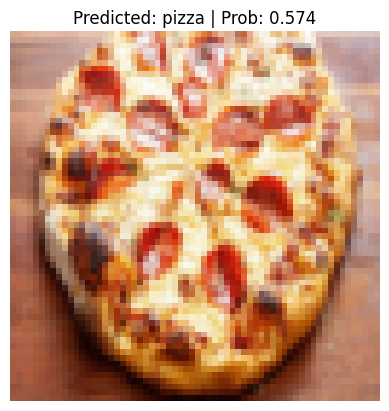

In [98]:
pred_plot(model, custom_image_path, class_names, custom_image_transform, "cpu")

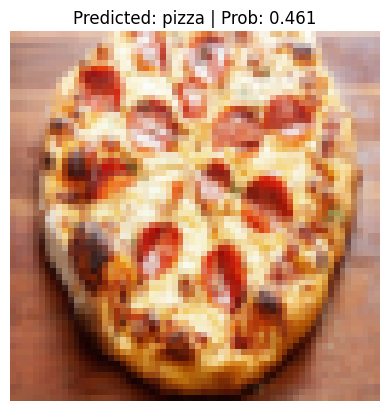

In [99]:
pred_plot(model1, custom_image_path, class_names, custom_image_transform, "cpu")